In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from time import sleep
import requests
import json
from pathlib import Path

In [ ]:
SPU_023201
LOC582406', 'LOC11098799
SPU_007592
LOC591079', 'LOC110985030

In [2]:
#we wanted overlapping with> lvar, chip, atac. NOT other from gff, lnc in vs
#here, we combine chip and atac - we keep all of chip and atac but to avoid issues, if they overlap, we make them into one region
#then we do the rest the same way

In [3]:
#still have to check to make sure no ranges overlap within type (eg atac)
#also compare with already selected list of enhancers

In [4]:
#we should also set a minimum length of a range to consider. 50 bp? lower range of enhancers

# important functions

In [5]:
def df2dic(al, intervals):
    ranges = { interval : defaultdict(list) for interval in intervals }
    for Var in intervals:
        temp_df = al[al["type"]==Var]
        for index, row in temp_df.iterrows():
            ranges[Var][row['chr']].append([row['start'],row['stop']])
    return ranges

In [6]:
def unzip(l):
    return list(zip(*l))

In [7]:
def range_merge(A, B):
    A0, A1 = A
    B0, B1 = B
    # return overlap, A', B'
    if( A1 < B0): # no overlap
        return [], [], B
    if(B1 < A0 ): # no overlap
        return [], A, []
    if ( A0 < B0 and B0 <= A1 and A1 <= B1) : # tail left
        return [B0, A1], [], [A1,B1]
    if (B0 <= A0 and A0 <= B1 and B1 < A1): # tail right
        return [A0, B1], [B1, A1], []
    if ( B0 <= A0 and A1 <= B1): # superset A ⊂ B
        return [A0, A1], [], [A1,B1]
    if (A0 < B0 and B1 < A1): # subset B ⊂ A
        return [B0, B1], [B1,A1], []
    else:
        print("ERROR:",A, B)

In [8]:
def interval_to_line(I,y):
    return list(range(I[0],I[1])), [y] * (I[1]-I[0])

def test_intervals(A,B):
    C, A_p, B_p = range_merge(A,B)
    plt.plot(*interval_to_line(A,1), label="A", color="red")
    plt.plot(*interval_to_line(B,0), label="B", color="blue")
    if len(C) > 0:
        plt.plot(*interval_to_line(C,-1), label="C", color="purple")
    if len(A_p) > 0:
        plt.plot(*interval_to_line(A_p,-2), label="A_p", color="red")
    if len(B_p) > 0:
        plt.plot(*interval_to_line(B_p,-3), label="B_p", color="blue")
    plt.legend()
    plt.show()

In [9]:
def compute_overlaps(As,Bs, debug=False):
    ai, bi = 0,0
    overlaps = []
    
    A = As[ai]
    B = Bs[bi]
    safety = 0
    max_safety = 1e6
    while True and safety < max_safety:
        safety += 1
        C, A_p, B_p = range_merge(A,B)

        if len(C) > 0:
            overlaps.append(C)
            if debug:
                print(A,B,C)

        if len(A_p) == 0:
            ai += 1
            if ai >= len(As):
                return overlaps
            else:
                A = As[ai]
        else:
            A = A_p

        if len(B_p) == 0:
            bi += 1
            if bi >= len(Bs):
                return overlaps
            else:
                B = Bs[bi]
        else:
            B = B_p
    
    if safety >= max_safety:
        print("YOU ARE A FAILURE")

In [49]:
def get_merge_results(all_chrs, al, kind1, kind2, ranges):
    ref=ranges[kind1]
    alt=ranges[kind2]
    results = pd.DataFrame() 
    for ch in all_chrs:
        if (len(al[(al["chr"]==ch) & (al["type"]==kind1)]) > 0) & (len(al[(al["chr"]==ch) & (al["type"]==kind2)])>0):
            new_contig = compute_overlaps(ref[ch], alt[ch], debug=False)
            for c in new_contig:
                results = results.append({'chr' : ch, 'start' : c[0], 'stop' : c[1]},  
                        ignore_index = True) 
    results.start = results.start.astype(int)
    results.stop = results.stop.astype(int)
    return results

In [11]:
def get_sub_results(all_chrs, al, kind1, kind2, ranges):
    ref=ranges[kind1]
    alt=ranges[kind2]
    results = pd.DataFrame() 
    for ch in all_chrs:
        if len(al[(al["chr"]==ch) & (al["type"]==kind1)]) > 0:
            new_contig = subtract_scaffold(ref[ch], alt[ch])
            for c in new_contig:
                results = results.append({'chr' : ch, 'start' : c[0], 'stop' : c[1]},  
                        ignore_index = True) 
    results.start = results.start.astype(int)
    results.stop = results.stop.astype(int)
    return results

In [12]:
def subtract_scaffold(contig, enemy, debug=False, max_safety=1e6):
    good_idx = 0
    evil_idx = 0
    safety = 0 #this is to avoid an infinite while loop

    while True and safety < max_safety:
        if(good_idx >= len(contig) or evil_idx >= len(enemy)):
            print("YOU ARE A FAILURE.")
            break
        good = contig[good_idx]
        evil = enemy[evil_idx]
        good_start, good_end = good[0], good[1]
        evil_start, evil_end = evil[0], evil[1]
        if debug:
            print(f"checking {good} {evil} :",end=" ")
        if(check_overlap(good,evil)):
            print("OVERLAPPED")
            print(good, evil)
            if debug:
                print("overlap")
            segments = range_takeout(good,evil)
            if debug:
                print("segments",segments)
            contig = contig[:good_idx] + segments + contig[good_idx+1:]
            if debug:
                print("new",contig[good_idx-1:good_idx+2], "current idx", contig[good_idx])
                
            if(good_idx >= len(contig) or evil_idx >= len(enemy)):
                print("extra check saved us.")
                break

        else:
            if(evil_end <= good_start):
                if debug:
                    print("evil")
                evil_idx += 1
                if(evil_idx >= len(enemy)):
                    if debug:
                        print("EVIL FINISHED")
                    break
                if debug:
                    print("next evil", enemy[evil_idx])
            else:
                if debug:
                    print("good")
                good_idx += 1
                if(good_idx >= len(contig)):
                    if debug:
                        print("GOOD FINISHED")
                    break
                if debug:
                    print("next good", contig[good_idx])

        safety += 1
    if debug:
        print(safety)
    return contig

In [13]:
#quick check if two regions overlap
def check_overlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0])) > 0

In [14]:
def range_takeout(contig, evil):
    A0, A1 = contig #region that we like, e.g. conserved region, start and end respectively, start being the lower number no matter the direction of the gene for example
    B0, B1 = evil #region that we don't want in the end, e.g. coding region, start and end
    if( A1 < B0 or B1 < A0 ): # no overlap
        return [contig]
    elif ( A0 < B0 and B0 <= A1 and A1 <= B1) : # tail left
        return [[A0, B0]]
    elif (B0 <= A0 and A0 <= B1 and B1 < A1): # tail right
        return [[B1, A1]]
    elif ( B0 <= A0 and A1 <= B1): # superset
        return []
    elif (A0 < B0 and B1 < A1): # subset
        return [[A0,B0],[B1,A1]]
    else:
        print("ERROR:",contig, evil)

In [24]:
def clean_segments(src):
    if len(src) <= 1:
        return src
    
    a = src[0]
    dest = []
    for b in src[1:]:
        # print(a,b, check_overlap(a,b))
        if check_overlap(a,b):
            a = (min(a[0],b[0]),max(a[1],b[1]))
        else:
            dest.append(a)
            a = b
    dest.append(a)
    return dest

In [25]:
def get_segs(df, chromosome):
    return [(start,stop) for _,(_,start,stop) in df[df['chr']==chromosome].iterrows()]

# step 1: overlap between atac and chip

In [15]:
reference = "atac"
toadd = ["chip"]
intervals = [reference] + toadd
intervals

['atac', 'chip']

In [16]:
atac = pd.read_csv("atac_mapped_translatedto5.0.csv", header=None, names=["chr","start","stop"])
chip = pd.read_csv('AlxChip_mapped_translatedto5.0.txt', sep="\t", header=None, names=["chr","start","stop"])

#processing dataframes
atac["type"] = "atac"
chip["type"] = "chip"
atac=atac.sort_values(by=["chr",'start'])
chip=chip.sort_values(by=["chr",'start'])
al = pd.concat([atac, chip])
all_chrs=al.chr.unique()
al["length"] = al["stop"] - al["start"]

#CHECK IF THERE ARE NEGATIVE NUMBERS
min(al["length"]) <= 0

False

In [18]:
al=al.drop(columns=['type','length'])

In [20]:
al=al.sort_values(by=["chr",'start'])

In [22]:
all_chrs=al.chr.unique()

In [26]:
results = pd.DataFrame()
i=1
for ch in all_chrs:
    #print(i)
    src = get_segs(al,ch)
    tmp = clean_segments(src)
    for t in tmp:
        results = results.append({'chr' : ch, 'start' : t[0], 'stop' : t[1]}, ignore_index = True) 
    i=i+1

In [32]:
results["start"]= results["start"].astype(int)
results["stop"]= results["stop"].astype(int)

In [40]:
len(results)

3512

In [41]:
results

,chr,start,stop,type
0,NW_022145150.1,60586,60784,atac_chip
1,NW_022145161.1,113455,113741,atac_chip
2,NW_022145172.1,1637,1933,atac_chip
3,NW_022145214.1,1,218,atac_chip
4,NW_022145214.1,3113,3314,atac_chip
...,...,...,...,...
3507,NW_022145615.1,34390828,34391041,atac_chip
3508,NW_022145615.1,34609662,34609860,atac_chip
3509,NW_022145615.1,34733679,34733867,atac_chip
3510,NW_022145615.1,34778475,34778663,atac_chip


# step 2: overlap with lvar

In [34]:
reference = "atac_chip"
toadd = ["lvar"]
intervals = [reference] + toadd
intervals

['atac_chip', 'lvar']

In [35]:
lvar = pd.read_csv('lvar_spur_48_50_mapped_translatedto50.csv', header=None, names=["chr","start","stop"])

#processing dataframes
results["type"] = "atac_chip"
lvar["type"] = "lvar"
results=results.sort_values(by=["chr",'start'])
lvar=lvar.sort_values(by=["chr",'start'])
al = pd.concat([results, lvar])
all_chrs=al.chr.unique()
al["length"] = al["stop"] - al["start"]

#CHECK IF THERE ARE NEGATIVE NUMBERS
min(al["length"]) <= 0

False

In [37]:
#make it into a dictionary 
ranges = df2dic(al, intervals)

In [50]:
results=get_merge_results(all_chrs, al, "atac_chip","lvar", ranges)

In [51]:
len(results)

436

In [52]:
results

,chr,start,stop
0,NW_022145514.1,743559,743624
1,NW_022145514.1,780152,780207
2,NW_022145516.1,1525158,1525179
3,NW_022145516.1,1525179,1525179
4,NW_022145531.1,141322,141410
...,...,...,...
431,NW_022145615.1,32749134,32749349
432,NW_022145615.1,32789529,32789594
433,NW_022145615.1,32802444,32802512
434,NW_022145615.1,32802960,32802971


# step 3: take out lncRNA

In [54]:
reference = "atac_chip"
subtractables = ["lnc"]
intervals = [reference] + subtractables
intervals

['atac_chip', 'lnc']

In [55]:
lnc = pd.read_csv("lncRNA_mapped_translatedto5.0.csv", header=1, names=["chr","start","stop"])

#processing dataframes
results["type"] = "atac_chip"
lnc["type"] = "lnc"
results=results.sort_values(by=["chr",'start'])
lnc=lnc.sort_values(by=["chr",'start'])
al = pd.concat([results, lnc])
all_chrs=al.chr.unique()
al["length"] = al["stop"] - al["start"]

#CHECK IF THERE ARE NEGATIVE NUMBERS
min(al["length"]) < 0

False

In [56]:
#make it into a dictionary 
ranges = df2dic(al, intervals)

In [57]:
results = get_sub_results(all_chrs, al, "atac_chip", "lnc", ranges)

OVERLAPPED
[2350940, 2351012] [2340820, 2354503]
OVERLAPPED
[22021147, 22021204] [21950635, 22023282]
OVERLAPPED
[22021220, 22021274] [21950635, 22023282]
OVERLAPPED
[22021356, 22021438] [21950635, 22023282]
OVERLAPPED
[26339841, 26339897] [26331089, 26366813]
OVERLAPPED
[9848398, 9848451] [9779590, 9854032]
OVERLAPPED
[29836427, 29836449] [29833902, 29836570]
OVERLAPPED
[7246550, 7246617] [7237563, 7248308]
OVERLAPPED
[24567764, 24567856] [24563001, 24571303]
OVERLAPPED
[34152365, 34152649] [34140913, 34169193]
OVERLAPPED
[3725671, 3725730] [3712071, 3757248]
OVERLAPPED
[27498582, 27498644] [27496730, 27501954]
OVERLAPPED
[29622216, 29622265] [29610547, 29669216]
OVERLAPPED
[30003611, 30003674] [29962890, 30078985]
OVERLAPPED
[30003727, 30003784] [29962890, 30078985]
OVERLAPPED
[32051482, 32051562] [32045687, 32060753]
OVERLAPPED
[32051562, 32051573] [32045687, 32060753]
OVERLAPPED
[19398799, 19398870] [19397935, 19411436]


In [58]:
len(results)

418

In [59]:
results

,chr,start,stop
0,NW_022145514.1,743559,743624
1,NW_022145514.1,780152,780207
2,NW_022145516.1,1525158,1525179
3,NW_022145516.1,1525179,1525179
4,NW_022145531.1,141322,141410
...,...,...,...
413,NW_022145615.1,32749134,32749349
414,NW_022145615.1,32789529,32789594
415,NW_022145615.1,32802444,32802512
416,NW_022145615.1,32802960,32802971


# step 4: take out gff

In [60]:
reference = "atac_chip"
subtractables = ["gff"]
intervals = [reference] + subtractables
intervals

['atac_chip', 'gff']

In [61]:
gff = pd.read_csv("nonoverlapping_nointronpromoter_gffannotations.csv", header=1, names=["chr","start","stop"])

#processing dataframes
results["type"] = "atac_chip"
gff["type"] = "gff"
results=results.sort_values(by=["chr",'start'])
gff=gff.sort_values(by=["chr",'start'])
al = pd.concat([results, gff])
all_chrs=al.chr.unique()
al["length"] = al["stop"] - al["start"]

#CHECK IF THERE ARE NEGATIVE NUMBERS
min(al["length"]) < 0

False

In [62]:
#make it into a dictionary 
ranges = df2dic(al, intervals)

In [63]:
results = get_sub_results(all_chrs, al, "atac_chip", "gff", ranges)

OVERLAPPED
[743559, 743624] [740646, 766916]
OVERLAPPED
[1525158, 1525179] [1270316, 1572451]
OVERLAPPED
[141322, 141410] [141332, 197820]
OVERLAPPED
[26157, 26207] [25674, 29604]
OVERLAPPED
[26265, 26321] [25674, 29604]
OVERLAPPED
[36385, 36488] [8271, 48610]
extra check saved us.
OVERLAPPED
[1220200, 1220202] [1207836, 1306624]
OVERLAPPED
[1220432, 1220606] [1207836, 1306624]
OVERLAPPED
[1684889, 1684938] [1667941, 1724928]
extra check saved us.
OVERLAPPED
[395488, 395556] [395502, 396627]
OVERLAPPED
[688120, 688198] [684306, 688580]
OVERLAPPED
[1590989, 1591039] [1560477, 1622764]
extra check saved us.
OVERLAPPED
[674811, 674867] [673763, 691616]
extra check saved us.
OVERLAPPED
[1536644, 1536716] [1535987, 1548629]
extra check saved us.
OVERLAPPED
[353709, 353733] [304830, 354607]
OVERLAPPED
[384699, 384753] [372341, 412679]
OVERLAPPED
[1180931, 1180983] [1176014, 1196167]
OVERLAPPED
[1395811, 1395954] [1392798, 1463703]
OVERLAPPED
[1733755, 1733814] [1732900, 1759560]
OVERLAPPED
[

In [64]:
len(results)

168

In [176]:
results

,chr,start,stop
0,NW_022145516.1,1525179,1525179
1,NW_022145531.1,141322,141332
2,NW_022145533.1,12539,12589
3,NW_022145533.1,12814,12875
4,NW_022145533.1,31423,31475
5,NW_022145547.1,341798,341798
6,NW_022145547.1,395488,395501
7,NW_022145565.1,384753,384753
8,NW_022145594.1,21196056,21196056
9,NW_022145594.1,41436041,41436041


In [175]:
our_chrs = results.chr.unique()

# step 5: take out liftover from 3.1

In [174]:
def get_lift_data(scaffold):
    info=[]
    json_url = f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/sp3_1_lift/{scaffold}/trackData.json"
    resp = requests.get(url=json_url)
    if(resp.ok):
        data = resp.json()
        info.extend([{"chr":scaffold,"start":el[1],"end":el[2]} for el in data["intervals"]["nclist"]])
    else:
        print("error")
    
    return(info)

In [145]:
liftdf = pd.DataFrame()
for ch in our_chrs:
    temp=get_lift_data(ch)
    tdf = pd.DataFrame(temp)
    liftdf = pd.concat([liftdf,tdf])

In [146]:
liftdf

,chr,start,end
0,NW_022144953.1,121,131
1,NW_022144953.1,121,131
2,NW_022144953.1,140,150
3,NW_022144953.1,141,151
4,NW_022144953.1,198,207
...,...,...,...
161,NW_022144953.1,8623,8637
162,NW_022144953.1,8623,8637
163,NW_022144953.1,8631,8639
164,NW_022144953.1,8801,8809


In [70]:
#making sure they are not overlapping

In [71]:
liftdf=liftdf.sort_values(by=["chr",'start'])
all_chrs=liftdf.chr.unique()

In [75]:
len(all_chrs)

31

In [74]:
tresults = pd.DataFrame()
i=1
for ch in all_chrs:
    print(i)
    src = get_segs(liftdf,ch)
    tmp = clean_segments(src)
    for t in tmp:
        tresults = tresults.append({'chr' : ch, 'start' : t[0], 'stop' : t[1]}, ignore_index = True) 
    i=i+1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [76]:
tresults

,chr,start,stop
0,NW_022145514.1,165167.0,167733.0
1,NW_022145514.1,181741.0,187821.0
2,NW_022145514.1,190155.0,196178.0
3,NW_022145514.1,201841.0,211494.0
4,NW_022145514.1,223849.0,229455.0
...,...,...,...
1191,NW_022145615.1,32737952.0,33436232.0
1192,NW_022145615.1,33459730.0,33762019.0
1193,NW_022145615.1,33762932.0,34250084.0
1194,NW_022145615.1,34310648.0,34971428.0


In [77]:
tresults["start"]= tresults["start"].astype(int)
tresults["stop"]= tresults["stop"].astype(int)

In [78]:
tresults

,chr,start,stop
0,NW_022145514.1,165167,167733
1,NW_022145514.1,181741,187821
2,NW_022145514.1,190155,196178
3,NW_022145514.1,201841,211494
4,NW_022145514.1,223849,229455
...,...,...,...
1191,NW_022145615.1,32737952,33436232
1192,NW_022145615.1,33459730,33762019
1193,NW_022145615.1,33762932,34250084
1194,NW_022145615.1,34310648,34971428


In [79]:
results

,chr,start,stop
0,NW_022145514.1,780152,780207
1,NW_022145516.1,1525179,1525179
2,NW_022145531.1,141322,141332
3,NW_022145533.1,12539,12589
4,NW_022145533.1,12814,12875
...,...,...,...
163,NW_022145615.1,30385781,30385829
164,NW_022145615.1,32789529,32789594
165,NW_022145615.1,32802444,32802512
166,NW_022145615.1,32802960,32802971


In [80]:
reference = "atac_chip"
subtractables = ["lift"]
intervals = [reference] + subtractables
intervals

['atac_chip', 'lift']

In [83]:
#processing dataframes
results["type"] = "atac_chip"
tresults["type"] = "lift"
results=results.sort_values(by=["chr",'start'])
tresults=tresults.sort_values(by=["chr",'start'])
al = pd.concat([results, tresults])
all_chrs=al.chr.unique()
al["length"] = al["stop"] - al["start"]

#CHECK IF THERE ARE NEGATIVE NUMBERS
min(al["length"]) < 0

False

In [84]:
al

,chr,start,stop,type,length
0,NW_022145514.1,780152,780207,atac_chip,55
1,NW_022145516.1,1525179,1525179,atac_chip,0
2,NW_022145531.1,141322,141332,atac_chip,10
3,NW_022145533.1,12539,12589,atac_chip,50
4,NW_022145533.1,12814,12875,atac_chip,61
...,...,...,...,...,...
1191,NW_022145615.1,32737952,33436232,lift,698280
1192,NW_022145615.1,33459730,33762019,lift,302289
1193,NW_022145615.1,33762932,34250084,lift,487152
1194,NW_022145615.1,34310648,34971428,lift,660780


In [85]:
#make it into a dictionary 
ranges = df2dic(al, intervals)

In [86]:
results = get_sub_results(all_chrs, al, "atac_chip", "lift", ranges)

OVERLAPPED
[780152, 780207] [738561, 804976]
extra check saved us.
OVERLAPPED
[1334079, 1334132] [1214279, 1348546]
OVERLAPPED
[1334763, 1334826] [1214279, 1348546]
OVERLAPPED
[1334855, 1334975] [1214279, 1348546]
extra check saved us.
OVERLAPPED
[1172434, 1172482] [22089, 1424427]
extra check saved us.
OVERLAPPED
[395488, 395502] [395501, 395627]
OVERLAPPED
[2432594, 2432658] [2049244, 2731659]
OVERLAPPED
[2442813, 2442874] [2049244, 2731659]
extra check saved us.
OVERLAPPED
[934172, 934290] [13671, 2570364]
OVERLAPPED
[934342, 934375] [13671, 2570364]
OVERLAPPED
[1964385, 1964435] [13671, 2570364]
extra check saved us.
OVERLAPPED
[1409098, 1409170] [942396, 1488092]
extra check saved us.
OVERLAPPED
[37419203, 37419262] [33923896, 39152902]
OVERLAPPED
[40376691, 40376779] [39157374, 41817495]
OVERLAPPED
[40376783, 40376838] [39157374, 41817495]
OVERLAPPED
[40383369, 40383418] [39157374, 41817495]
OVERLAPPED
[40422486, 40422527] [39157374, 41817495]
OVERLAPPED
[40986392, 40986480] [391

In [88]:
len(results)

40

In [89]:
our_chrs = results.chr.unique()

In [90]:
our_chrs

array(['NW_022145516.1', 'NW_022145531.1', 'NW_022145533.1',
       'NW_022145547.1', 'NW_022145565.1', 'NW_022145594.1',
       'NW_022145595.1', 'NW_022145599.1', 'NW_022145600.1',
       'NW_022145601.1', 'NW_022145602.1', 'NW_022145604.1',
       'NW_022145607.1', 'NW_022145609.1', 'NW_022145610.1',
       'NW_022145612.1', 'NW_022145613.1', 'NW_022145615.1'], dtype=object)

In [91]:
results

,chr,start,stop
0,NW_022145516.1,1525179,1525179
1,NW_022145531.1,141322,141332
2,NW_022145533.1,12539,12589
3,NW_022145533.1,12814,12875
4,NW_022145533.1,31423,31475
5,NW_022145547.1,341798,341798
6,NW_022145547.1,395488,395501
7,NW_022145565.1,384753,384753
8,NW_022145594.1,21196056,21196056
9,NW_022145594.1,41436041,41436041


# step 6: overlap with TFBS

In [ ]:
#this takes too long... if chromosome too big, look up manually...

In [97]:
def get_TFBS_data(scaffold):
    info=[]
    i=1
    while True:
        if i < 100:
            json_url = f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/TFBS/{scaffold}/lf-{i}.json"
            resp = requests.get(url=json_url)
            if(resp.ok):
                data = resp.json()
                info.extend([{"chr":scaffold,"start":el[1],"end":el[2]} for el in data])
            else:
                print("done")
                print(i)
                return(info, i)
            sleep(0.2)
            i=i+1
        else:
            return(i)

In [99]:
tfdf = pd.DataFrame()
for ch in our_chrs:
    print(ch)
    temp=get_TFBS_data(ch)
    if type(temp) != int:
        print(tmp, type(temp))
        tdf = pd.DataFrame(temp)
        filename = f"TFBS_scaffold{ch}.csv"
        if(not Path(filename).exists()):
            tdf.to_csv(filename,index=False)
        tfdf = pd.concat([tfdf,tdf])
    else:
        print("it was too long")

NW_022145516.1
it was too long
NW_022145531.1
done
45


TypeError: object of type 'int' has no len()

In [126]:
import re
def get_lfs_for_chromosome(chromosome):
    resp = requests.get(f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/TFBS/{chromosome}/")
    return re.findall("href=\"(lf-[^\"]*\.json)",resp.text)

In [127]:
lfs = get_lfs_for_chromosome("NW_022145516.1")
print(len(lfs),lfs)

290 ['lf-1.json', 'lf-2.json', 'lf-3.json', 'lf-4.json', 'lf-5.json', 'lf-6.json', 'lf-7.json', 'lf-8.json', 'lf-9.json', 'lf-10.json', 'lf-11.json', 'lf-12.json', 'lf-13.json', 'lf-14.json', 'lf-15.json', 'lf-16.json', 'lf-17.json', 'lf-18.json', 'lf-19.json', 'lf-20.json', 'lf-21.json', 'lf-22.json', 'lf-23.json', 'lf-24.json', 'lf-25.json', 'lf-26.json', 'lf-27.json', 'lf-28.json', 'lf-29.json', 'lf-30.json', 'lf-31.json', 'lf-32.json', 'lf-33.json', 'lf-34.json', 'lf-35.json', 'lf-36.json', 'lf-37.json', 'lf-38.json', 'lf-39.json', 'lf-40.json', 'lf-41.json', 'lf-42.json', 'lf-43.json', 'lf-44.json', 'lf-45.json', 'lf-46.json', 'lf-47.json', 'lf-48.json', 'lf-49.json', 'lf-50.json', 'lf-51.json', 'lf-52.json', 'lf-53.json', 'lf-54.json', 'lf-55.json', 'lf-56.json', 'lf-57.json', 'lf-58.json', 'lf-59.json', 'lf-60.json', 'lf-61.json', 'lf-62.json', 'lf-63.json', 'lf-64.json', 'lf-65.json', 'lf-66.json', 'lf-67.json', 'lf-68.json', 'lf-69.json', 'lf-70.json', 'lf-71.json', 'lf-72.jso

In [173]:
resp = requests.get(f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/TFBS/")
tracks = re.findall("href=\"([NC][^\"]*)/",resp.text)
tracks[:10]

['NC_001453.1',
 'NW_022144746.1',
 'NW_022144747.1',
 'NW_022144748.1',
 'NW_022144749.1',
 'NW_022144750.1',
 'NW_022144751.1',
 'NW_022144752.1',
 'NW_022144753.1',
 'NW_022144754.1']

In [135]:
tracks_lfs = {}
for i, track in enumerate(tracks):
    print(f"\r{i}/{len(tracks)}",end="")
    if track not in tracks_lfs:
        tracks_lfs[track] = len(get_lfs_for_chromosome(track))

870/871

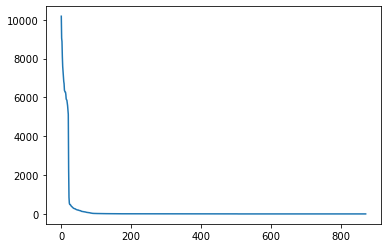

In [138]:
import matplotlib.pyplot as plt

plt.plot(sorted(tracks_lfs.values(),reverse=True))

In [150]:
def get_trackData(scaffold):
    json_url = f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/TFBS/{scaffold}/trackData.json"
    resp = requests.get(url=json_url)
    if(resp.ok):
        data = resp.json()
        info = [{"chr":scaffold,"start":el[1],"end":el[2]} for el in data["intervals"]["nclist"]]
        return(info)
    else:
        raise RuntimeError(scaffold)

In [160]:
get_trackData("NW_022144953.1")[:10]

[{'chr': 'NW_022144953.1', 'start': 121, 'end': 131},
 {'chr': 'NW_022144953.1', 'start': 121, 'end': 131},
 {'chr': 'NW_022144953.1', 'start': 140, 'end': 150},
 {'chr': 'NW_022144953.1', 'start': 141, 'end': 151},
 {'chr': 'NW_022144953.1', 'start': 198, 'end': 207},
 {'chr': 'NW_022144953.1', 'start': 280, 'end': 288},
 {'chr': 'NW_022144953.1', 'start': 330, 'end': 342},
 {'chr': 'NW_022144953.1', 'start': 333, 'end': 343},
 {'chr': 'NW_022144953.1', 'start': 333, 'end': 343},
 {'chr': 'NW_022144953.1', 'start': 334, 'end': 344}]

In [157]:
def get_TFBS_data(scaffold,n):
    info=[]
    for i in range(1,n+1):
        json_url = f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/TFBS/{scaffold}/lf-{i}.json"
        resp = requests.get(url=json_url)
        if(resp.ok):
            data = resp.json()
            info.extend([{"chr":scaffold,"start":el[1],"end":el[2]} for el in data])
        else:
            raise RuntimeError(scaffold)
        sleep(0.2)
    return info

In [161]:
get_TFBS_data("NW_022144787.1",2)[:10]

[{'chr': 'NW_022144787.1', 'start': 0, 'end': 10},
 {'chr': 'NW_022144787.1', 'start': 0, 'end': 10},
 {'chr': 'NW_022144787.1', 'start': 0, 'end': 10},
 {'chr': 'NW_022144787.1', 'start': 0, 'end': 10},
 {'chr': 'NW_022144787.1', 'start': 44, 'end': 53},
 {'chr': 'NW_022144787.1', 'start': 133, 'end': 147},
 {'chr': 'NW_022144787.1', 'start': 187, 'end': 199},
 {'chr': 'NW_022144787.1', 'start': 190, 'end': 201},
 {'chr': 'NW_022144787.1', 'start': 277, 'end': 294},
 {'chr': 'NW_022144787.1', 'start': 292, 'end': 300}]

In [162]:
TFDATA = {}
for n, chromosome in sorted(list(zip(tracks_lfs.values(),tracks_lfs.keys()))):
    if chromosome not in TFDATA:
        if n == 0:
            data = get_trackData(chromosome)
        else:
            data = get_TFBS_data(chromosome,n)
        TFDATA[chromosome] = data

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [ ]:
liftdf = pd.DataFrame()
for ch in our_chrs:
    temp=get_lift_data(ch)
    tdf = pd.DataFrame(temp)
    liftdf = pd.concat([liftdf,tdf])

In [170]:
sum([i if i != 0 else 1 for i in tracks_lfs.values()]) * 50_000 / 1_000_000_000

8.02975

In [171]:
sum([i if i != 0 else 1 for i in tracks_lfs.values()])

160595

In [ ]:
class TFDataset():
    def __init__(self, root):
        self.root = root
        self.url = f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/TFBS/"
        resp = requests.get(f"https://jbrowse.echinobase.org/JBrowse/data/sp5_0/tracks/TFBS/")
        # TODO: serialize
        self.chromosomes = re.findall("href=\"([NC][^\"]*)/",resp.text)
        
    def avail_chrs(self):
        return self.chromosomes
    
    def get_chrs(self, chrs)
        for ch in chrs:
            assert ch in self.chromosomes
            
        data = {}
        for i, ch in enumerate(chrs):
            tracks_lfs[ch] = len(get_lfs_for_chromosome(ch))
        
        